# 📊 EDA и исследовательский анализ

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

# Предварительная подготовка

In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import os.path as osp
from glob import glob
import json
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rootpath = "/content/drive/MyDrive/driving-segmentation-inclass-competition"
train_dir = osp.join(rootpath, "train")
test_dir = osp.join(rootpath, "test")
config_path = osp.join(rootpath, "config.json")
with open(config_path) as f:
    config = json.load(f)

class_num = len(config['labels'])
img_size = (1920, 1080)

In [ ]:
# словарь для хранения информации о метках с идентификатором в качестве ключа
labels_map = {}
for label_dict in config['labels']:
    labels_map[label_dict['id']] = label_dict
    del label_dict['id']
labels_map

{1: {'label': 'vehicle', 'color': [0, 0, 142]},
 2: {'label': 'pedestrian', 'color': [220, 20, 60]},
 3: {'label': 'road', 'color': [128, 64, 128]},
 4: {'label': 'sidewalk', 'color': [244, 35, 232]},
 5: {'label': 'bicycle', 'color': [119, 11, 32]},
 6: {'label': 'motorcycle', 'color': [0, 0, 230]},
 7: {'label': 'building', 'color': [70, 70, 70]},
 8: {'label': 'terrain', 'color': [152, 251, 152]},
 9: {'label': 'vegetation', 'color': [107, 142, 35]},
 10: {'label': 'pole', 'color': [153, 153, 153]},
 11: {'label': 'traffic light', 'color': [250, 170, 30]},
 12: {'label': 'traffic sign', 'color': [220, 220, 0]}}

In [ ]:
img_list, anno_list = sorted(glob(osp.join(train_dir, 'frames/*'))), sorted(glob(osp.join(train_dir, 'labels/*')))
len(img_list), len(anno_list)

(3500, 3500)

# Датасет

In [ ]:
# среднее значение цвета и стандартное отклонение
input_size = 512
encoder = 'resnet34'

# получаем функцию предварительной обработки для pytorch-segmentation
preprocess_input = get_preprocessing_fn(encoder, pretrained='imagenet')

# для обучения
train_transform = A.Compose([
    A.Rotate((-10, 10)),
    A.HorizontalFlip(p=0.5),
    A.Resize(input_size, input_size),
    A.Lambda(image=preprocess_input),
    ToTensorV2(),
])

# для проверки
val_transform = A.Compose([
    A.Resize(input_size, input_size),
    A.Lambda(image=preprocess_input),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
class Dataset(data.Dataset):

    def __init__(self, img_list, anno_list=None, transform=None):
        self.img_list = img_list
        self.anno_list = anno_list
        self.transform = transform

    def __len__(self):
        '''Возвращает количество изображений'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        Получает изображение и аннотацию в формате Tensor после предварительной обработки
        '''
        # 1. Загрузка изображения
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)   # [высота][ширина][цвет RGB]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 2. Загрузка аннотации (если есть)
        anno_class_img = torch.tensor(float('nan'))
        if self.anno_list is not None:
            anno_file_path = self.anno_list[index]
            anno_class_img = cv2.imread(anno_file_path, cv2.IMREAD_GRAYSCALE)  # [высота][ширина]

        # 3. Применение трансформаций (если заданы)
        if self.transform is not None:
            if self.anno_list is not None:
                transformed = self.transform(image=img, mask=anno_class_img)
                img, anno_class_img = transformed['image'], transformed['mask']
            else:
                transformed = self.transform(image=img)
                img = transformed['image']

        return img.float(), anno_class_img.float()

torch.Size([3, 512, 512])
torch.Size([512, 512])


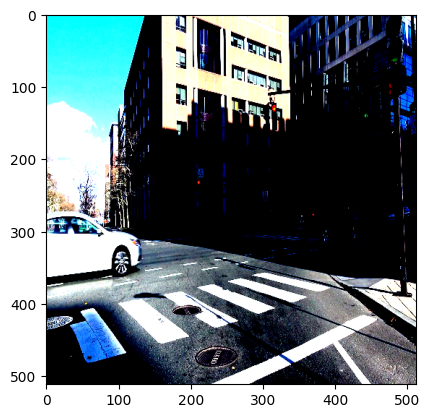

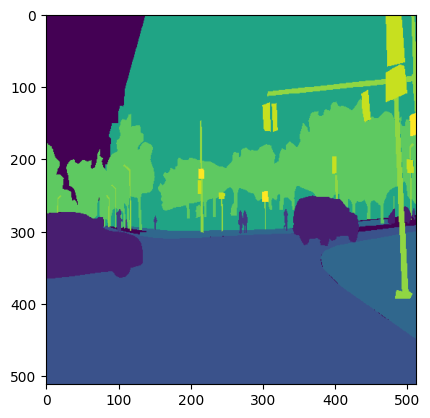

In [ ]:
# Проверка работоспособности

# Разделение данных на обучающую и валидационную выборки
train_img_list, val_img_list, train_anno_list, val_anno_list = train_test_split(img_list, anno_list)

# Создание датасетов
train_dataset = Dataset(train_img_list, train_anno_list, transform=train_transform)
val_dataset = Dataset(val_img_list, val_anno_list, transform=val_transform)

# Пример извлечения данных
img, anno_class_img = val_dataset[0]
print(img.shape)
print(anno_class_img.shape)

# Отображение изображения
img_val = img.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# Отображение аннотации
anno_class_img_val = anno_class_img.numpy()
plt.imshow(anno_class_img_val)
plt.show()

# Создание загрузчика данных

In [ ]:
batch_size = 28

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Проверка
batch_iterator = iter(train_dataloader)  # преобразовываем в итератор
imges, anno_class_imges = next(batch_iterator)  # извлекаем первый элемент
print(imges.size())  # torch.Size([8, 3, 512, 512])
print(anno_class_imges.size())  # torch.Size([8, 512, 512])

torch.Size([28, 3, 512, 512])
torch.Size([28, 512, 512])


# Модель

Создаём сегментационную нейросеть на основе архитектуры U-Net, используя библиотеку segmentation_models_pytorch (smp)

In [ ]:
model = smp.Unet(
    encoder_name=encoder,
    encoder_weights="imagenet",
    in_channels=3,
    classes=class_num+1,
)

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

# Обучение модели

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import numpy as np # For calculations

# --- User-defined Label Information (as before) ---
label_info_dict = {
    1: {'label': 'vehicle', 'color': [0, 0, 142]}, 2: {'label': 'pedestrian', 'color': [220, 20, 60]},
    3: {'label': 'road', 'color': [128, 64, 128]}, 4: {'label': 'sidewalk', 'color': [244, 35, 232]},
    5: {'label': 'bicycle', 'color': [119, 11, 32]}, 6: {'label': 'motorcycle', 'color': [0, 0, 230]},
    7: {'label': 'building', 'color': [70, 70, 70]}, 8: {'label': 'terrain', 'color': [152, 251, 152]},
    9: {'label': 'vegetation', 'color': [107, 142, 35]}, 10: {'label': 'pole', 'color': [153, 153, 153]},
    11: {'label': 'traffic light', 'color': [250, 170, 30]}, 12: {'label': 'traffic sign', 'color': [220, 220, 0]}
}

# --- Helper Functions for F1 Score (Identical to previous version) ---
def calculate_pixel_metrics_per_class(predictions, targets, num_classes, device):
    # ... (same as before)
    tp_per_class = torch.zeros(num_classes, device=device, dtype=torch.float)
    fp_per_class = torch.zeros(num_classes, device=device, dtype=torch.float)
    fn_per_class = torch.zeros(num_classes, device=device, dtype=torch.float)
    for c_idx in range(num_classes):
        pred_is_c = (predictions == c_idx)
        target_is_c = (targets == c_idx)
        tp_per_class[c_idx] += (pred_is_c & target_is_c).sum()
        fp_per_class[c_idx] += (pred_is_c & ~target_is_c).sum()
        fn_per_class[c_idx] += (~pred_is_c & target_is_c).sum()
    return tp_per_class, fp_per_class, fn_per_class

def calculate_f1_from_tp_fp_fn(tp, fp, fn, epsilon=1e-7):
    # ... (same as before)
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    f1 = torch.nan_to_num(f1, nan=0.0)
    macro_f1 = f1.mean().item()
    return f1, macro_f1

# --- Assuming model, train_dataloader, val_dataloader are defined ---
# Example:
# model = YourSegmentationModel(num_classes=NUM_CLASSES)
# train_dataloader = ... (Make sure this is your training dataloader)
# val_dataloader = ...

NUM_CLASSES = 13 # Assuming class 0 is background
print(f"Number of classes (including background if index 0 is used): {NUM_CLASSES}")

class_index_to_name_map = ["background"]
for i in range(1, NUM_CLASSES):
    if i in label_info_dict: class_index_to_name_map.append(label_info_dict[i]['label'])
    else: class_index_to_name_map.append(f"class_{i}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# --- Calculate Class Weights ---
print("Calculating class weights from training data...")
# Ensure train_dataloader is defined and gives (images, annotation_masks)
# It's important to iterate over the *entire* training dataset for accurate frequencies.
class_pixel_counts = torch.zeros(NUM_CLASSES, dtype=torch.float64, device='cpu') # Accumulate on CPU for potentially large datasets
total_pixels_in_dataset = 0

# It's good practice to use a dataloader without shuffling for this calculation,
# or ensure your main train_dataloader is iterated fully.
# If your train_dataloader shuffles, the order of batches will change,
# but the total counts will be the same if iterated fully.
temp_train_loader_for_weights = train_dataloader # Use your existing train_dataloader

for _, anno_class_imges_batch in tqdm(temp_train_loader_for_weights, desc="Counting class pixels"):
    # anno_class_imges_batch shape: (N, H, W)
    anno_class_imges_batch = anno_class_imges_batch.to('cpu') # Move to CPU for counting if not already
    total_pixels_in_dataset += anno_class_imges_batch.numel()
    for c_idx in range(NUM_CLASSES):
        class_pixel_counts[c_idx] += (anno_class_imges_batch == c_idx).sum()

print(f"Total pixels in dataset: {total_pixels_in_dataset}")
print(f"Pixel counts per class: {class_pixel_counts.tolist()}")

# Calculate weights: Median Frequency Balancing or Inverse Frequency
# Method 1: Inverse Frequency (simpler)
# class_weights = 1.0 / (class_pixel_counts + 1e-8) # Add epsilon to avoid div by zero
# class_weights = class_weights / class_weights.sum() * NUM_CLASSES # Normalize

# Method 2: Effective Number of Samples (ENS) like weighting (often robust)
# beta = 0.9999 # Hyperparameter, can be tuned
# effective_num = 1.0 - torch.pow(beta, class_pixel_counts)
# class_weights = (1.0 - beta) / (effective_num + 1e-8)
# class_weights = class_weights / torch.sum(class_weights) * NUM_CLASSES

# Method 3: Standard Inverse Class Frequency, normalized by total pixels
# This is a common and effective method.
# total_pixels = class_pixel_counts.sum() # This is total_pixels_in_dataset
class_frequencies = class_pixel_counts / total_pixels_in_dataset
class_weights = 1.0 / (class_frequencies + 1e-8) # Add epsilon for stability
# Normalize weights (optional, but can help stabilize training)
# class_weights = class_weights / class_weights.mean() # Normalize so mean is 1
# Or normalize so they sum to NUM_CLASSES or 1
class_weights = class_weights / class_weights.sum() * NUM_CLASSES


# Ensure no NaN or Inf weights if a class had zero pixels (shouldn't happen for defined classes)
class_weights = torch.nan_to_num(class_weights, nan=1.0, posinf=1.0, neginf=1.0) # Replace NaN/inf with 1.0

print(f"Calculated class weights: {class_weights.tolist()}")
class_weights_tensor = class_weights.float().to(device) # Move to the target device

# --- End Calculate Class Weights ---

num_epochs = 1 # Or your desired number of epochs
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# !!! Use the calculated weights in your criterion !!!
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# If you have an ignore_index (e.g., for a specific unlabeled class like 255), add it:
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=YOUR_IGNORE_INDEX)


model = model.to(device)
best_val_loss = float('inf')
best_val_macro_f1 = 0.0

# --- Training Loop (largely the same, but criterion now has weights) ---
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    epoch_train_tp_total = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float)
    epoch_train_fp_total = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float)
    epoch_train_fn_total = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float)

    print('-------------')
    print(f'epoch {epoch+1}/{num_epochs}')
    print('-------------')

    model.train()
    for i, (imges, anno_class_imges) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1} Train")):
        imges = imges.to(device)
        anno_class_imges = anno_class_imges.to(device)

        outputs = model(imges)
        loss = criterion(outputs, anno_class_imges.long()) # Criterion now uses weights

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        tp_batch, fp_batch, fn_batch = calculate_pixel_metrics_per_class(
            predicted, anno_class_imges, NUM_CLASSES, device
        )
        epoch_train_tp_total += tp_batch
        epoch_train_fp_total += fp_batch
        epoch_train_fn_total += fn_batch

        if (i + 1) % 10 == 0: # Or your desired print frequency
            batch_f1_scores, batch_macro_f1 = calculate_f1_from_tp_fp_fn(
                tp_batch, fp_batch, fn_batch
            )
            print(f'\nBatch {i+1}/{len(train_dataloader)} || Train Loss: {loss.item():.4f}')
            print(f"  Train Batch Macro F1: {batch_macro_f1:.4f}")
            print(f"  Train Batch Per-Label F1 Scores:")
            for class_idx, f1_val in enumerate(batch_f1_scores.tolist()):
                label_name = class_index_to_name_map[class_idx] if class_idx < len(class_index_to_name_map) else f"class_{class_idx}"
                print(f"    {label_name}: {f1_val:.3f}")

            model.eval()
            val_loss_total = 0.0
            val_tp_accumulated = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float)
            val_fp_accumulated = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float)
            val_fn_accumulated = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float)

            with torch.no_grad():
                for val_imges, val_anno in val_dataloader:
                    val_imges = val_imges.to(device)
                    val_anno = val_anno.to(device)
                    outputs_val = model(val_imges)
                    loss_val = criterion(outputs_val, val_anno.long()) # Criterion uses weights here too
                    val_loss_total += loss_val.item()
                    _, predicted_val = torch.max(outputs_val.data, 1)
                    tp_v, fp_v, fn_v = calculate_pixel_metrics_per_class(
                        predicted_val, val_anno, NUM_CLASSES, device
                    )
                    val_tp_accumulated += tp_v
                    val_fp_accumulated += fp_v
                    val_fn_accumulated += fn_v

            avg_val_loss = val_loss_total / len(val_dataloader)
            val_f1_per_class, val_macro_f1 = calculate_f1_from_tp_fp_fn(
                val_tp_accumulated, val_fp_accumulated, val_fn_accumulated
            )

            print(f'Batch {i+1} Validation || Loss: {avg_val_loss:.4f} || Macro F1: {val_macro_f1:.4f}')
            print(f"  Validation Per-Label F1 Scores:")
            for class_idx, f1_val in enumerate(val_f1_per_class.tolist()):
                label_name = class_index_to_name_map[class_idx] if class_idx < len(class_index_to_name_map) else f"class_{class_idx}"
                print(f"    {label_name}: {f1_val:.3f}")

            if val_macro_f1 > best_val_macro_f1:
                best_val_macro_f1 = val_macro_f1
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), 'best_model_f1_weighted.pth') # Save with new name
                print(f"New best model saved with Macro F1: {best_val_macro_f1:.4f}!")
            model.train()

    avg_epoch_train_loss = epoch_train_loss / len(train_dataloader)
    epoch_train_f1_per_class, epoch_train_macro_f1 = calculate_f1_from_tp_fp_fn(
        epoch_train_tp_total, epoch_train_fp_total, epoch_train_fn_total
    )
    print(f'\nFinal Epoch {epoch+1} Training Summary:')
    print(f'  Average Train Loss: {avg_epoch_train_loss:.4f}')
    print(f'  Train Macro F1: {epoch_train_macro_f1:.4f}')
    print(f"  Train Per-Label F1 Scores:")
    for class_idx, f1_val in enumerate(epoch_train_f1_per_class.tolist()):
        label_name = class_index_to_name_map[class_idx] if class_idx < len(class_index_to_name_map) else f"class_{class_idx}"
        print(f"    {label_name}: {f1_val:.3f}")

print("\nTraining Finished.")
print(f"Best Validation Macro F1: {best_val_macro_f1:.4f} (achieved with Loss: {best_val_loss:.4f})")
print("Best model weights saved to 'best_model_f1_weighted.pth'")

Number of classes (including background if index 0 is used): 13
使用デバイス： cpu
Calculating class weights from training data...


Counting class pixels: 100%|██████████| 94/94 [1:04:18<00:00, 41.04s/it]


Total pixels in dataset: 688128000
Pixel counts per class: [78494582.0, 37575993.0, 5534210.0, 201951382.0, 39396224.0, 754717.0, 0.0, 203095556.0, 2260162.0, 105450061.0, 8484761.0, 3333068.0, 1797284.0]
Calculated class weights: [1.1396300125422202e-06, 2.380636299603435e-06, 1.616394717269911e-05, 4.4295208766232755e-07, 2.2706433410048877e-06, 0.0001185265121855633, 12.999731054581348, 4.4045664042183215e-07, 3.957880760689381e-05, 8.483141937090206e-07, 1.0542986038384649e-05, 2.6838517734385924e-05, 4.977201533875326e-05]
-------------
epoch 1/1
-------------


Epoch 1 Train:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
pixel_counts = [
    78494582.0, 37575993.0, 5534210.0, 201951382.0, 39396224.0,
    754717.0, 0.0, 203095556.0, 2260162.0, 105450061.0,
    8484761.0, 3333068.0, 1797284.0
]

total_pixels = int(sum(pixel_counts))
print(f"Total pixels: {total_pixels:,}\n")

for i, count in enumerate(pixel_counts):
    print(f"Class {i:2d}: {int(count):>11,}")

Total pixels: 688,128,000

Class  0:  78,494,582
Class  1:  37,575,993
Class  2:   5,534,210
Class  3: 201,951,382
Class  4:  39,396,224
Class  5:     754,717
Class  6:           0
Class  7: 203,095,556
Class  8:   2,260,162
Class  9: 105,450,061
Class 10:   8,484,761
Class 11:   3,333,068
Class 12:   1,797,284


Выводы по итогу обучения:


> Класс 6 вообще не представлен (0 пикселей): модель не может обучиться на него - он будет всегда предсказан как "неизвестный".

> Классы с сильным дисбалансом: Классы 3 и 7 - очень доминирующие (по ~200 млн пикселей). Классы 5, 8, 11, 12 - очень редкие.



# Итог:

1. Дисбаланс классов сильный.
2. Класс 6	Отсутствует в обучающей выборке.
3. Обучение	Всего 1 эпоха - явно недостаточно для сходимости.
4. CPU вместо GPU	Очень медленно, желательно использовать GPU.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_f1_weighted.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_f1_weighted.pth'))

<All keys matched successfully>

In [ ]:
import os
print(os.listdir('/content/drive/MyDrive'))

['Colab Notebooks', 'Видео', '2020-05-20_13-59-19.png', '2020-05-20_13-59-36.png', '2020-05-20_14-14-27.png', 'NEW-MUSIC-NOSTYA.7z', 'Копия Новый Воркбук курса "Стратегия поступления".gsheet', 'декомпозиция.gdoc', 'МЕХАНИКА Физика.gdoc', 'Дизайн-док.gdoc', 'Копия Сценарий новеллы.gdoc', 'карта памяти (1).jpg', 'карта памяти.jpg', 'Письмо.gdoc', 'ТЕРМОДИНАМИКА ФИЗИКА.gdoc', 'Сценарий новеллы.gdoc', 'Sketching_A4 (1).gdoc', 'Sketching_A4.gdoc', 'Копия Sketching_A4.pdf', 'Копия Копия База по “История” УрФУ.gdoc', 'гейм-дизайн база.docx', 'БЖД.gdoc', 'Конышев А.В(5.6).ipynb', 'Конышев А.В(4.5).ipynb', 'Конышев А.В(6.7).ipynb', 'Конышев А.В(7.6).ipynb', 'Конышев А.В(8.6).ipynb', 'Конышев А.В(9.6).ipynb', 'Задачки на паре (Конышев А.В).ipynb', 'Конышев А.В(10.6).ipynb', 'Конышев А.В(11.6).ipynb', 'Конышев А. В(задание 2.2).ipynb', 'Конышев А.В(2.6).ipynb', 'Конышев А.В(2.7).ipynb', 'Конышев А.В(2.5) (1).ipynb', 'Конышев А.В(задачи на паре 19.10).ipynb', 'Конышев А.В(задачи на паре #2).

# Вывод предсказаний

In [ ]:
# Загружаем сохранённую обученную модель из файла best_model_f1_weighted.pth

model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_f1_weighted.pth'))

test_img_list, test_anno_list = sorted(glob(osp.join(test_dir, 'frames/*'))), sorted(glob(osp.join(test_dir, 'labels/*')))
test_dataset = Dataset(test_img_list, anno_list=None, transform=val_transform) # объект датасета Dataset
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # датасет оборачивается в DataLoader, чтобы можно было удобно и по батчам подавать данные в модель.

In [ ]:
# Пустой список preds для хранения предсказаний.

preds = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Проходим по тестовому даталоадеру - берём изображения
for imges, anno_class_imges in tqdm(test_dataloader):
    imges = imges.to(device)
    anno_class_imges = anno_class_imges.to(device)

    with torch.no_grad():
        outputs = model(imges)
        outputs = outputs.argmax(dim=1).detach().cpu().numpy().astype('uint8')

    preds += [outputs] # получаем вероятности по классам на каждый пиксель

preds = np.concatenate(preds) # соединяем все батчи в один массив

  0%|          | 0/54 [00:00<?, ?it/s]

# Создание файла для сабмита

In [ ]:
# Функция для кодирования маски в формат Run-Length Encoding (RLE)

# RLE - сжатое представление маски, где указываются длины подряд идущих пикселей объекта.
# Принимает бинарное изображение (1 - объект, 0 - фон), возвращает строку с RLE.

def rle_encode(img):
    """ TBD

    Args:
        img (np.array):
            - 1 indicating mask
            - 0 indicating background

    Returns:
        run length as string formated
    """

    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# Сохраняем готовый файл с предсказаниями в result.csv

result = pd.read_csv(osp.join(rootpath, 'sample_submission.csv'))
encoded_pixels = []
for pred in tqdm(preds):
    pred = cv2.resize(pred, dsize=img_size, interpolation=cv2.INTER_NEAREST)
    for label_id in range(1, class_num+1):
        rle = rle_encode(np.where(pred==label_id, 1, 0))
        encoded_pixels += [rle]
result['EncodedPixels'] = encoded_pixels
result.to_csv('result.csv', index=False)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

result = pd.read_csv('result.csv')
result.head()

,ImageId,EncodedPixels
0,003500_1,17390 4 17634 4 18605 4 18620 4 18763 3 18815 ...
1,003500_2,5829 4 6073 7 6144 7 6170 4 6294 15 6980 4 699...
2,003500_3,7108 7 7291 4 7333 3 9028 7 9211 4 9253 3 3036...
3,003500_4,13786 4 15350 4 15358 3 15706 4 17270 4 17278 ...
4,003500_5,17281 4 19201 4 175246 4 177166 4 750736 4 752...


In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/best_model_f1_weighted.pth', '/content/best_model_f1_weighted.pth')

from google.colab import files
files.download('/content/best_model_f1_weighted.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>